In [1]:
%load_ext autoreload
%autoreload 2
import barcoderegression
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.ndimage
import tqdm.notebook
import numpy.random as npr
import ipywidgets
import skimage
import skimage.feature

from barcoderegression.plotting import AnimAcross
%matplotlib inline

# from simulated data

In [10]:
with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    gene_names=example['gene_names']
    
npr.seed(0)
model,Xrav,X_without_noise = barcoderegression.simulations.simulation_from_B(
    example['barcode'],spatial_dims,100,blursize=[2.5,2.5],noise=.15,genedistr=example['genedistr'],lam=.05)
X=Xrav.reshape(spatial_dims+(model.R,model.C))

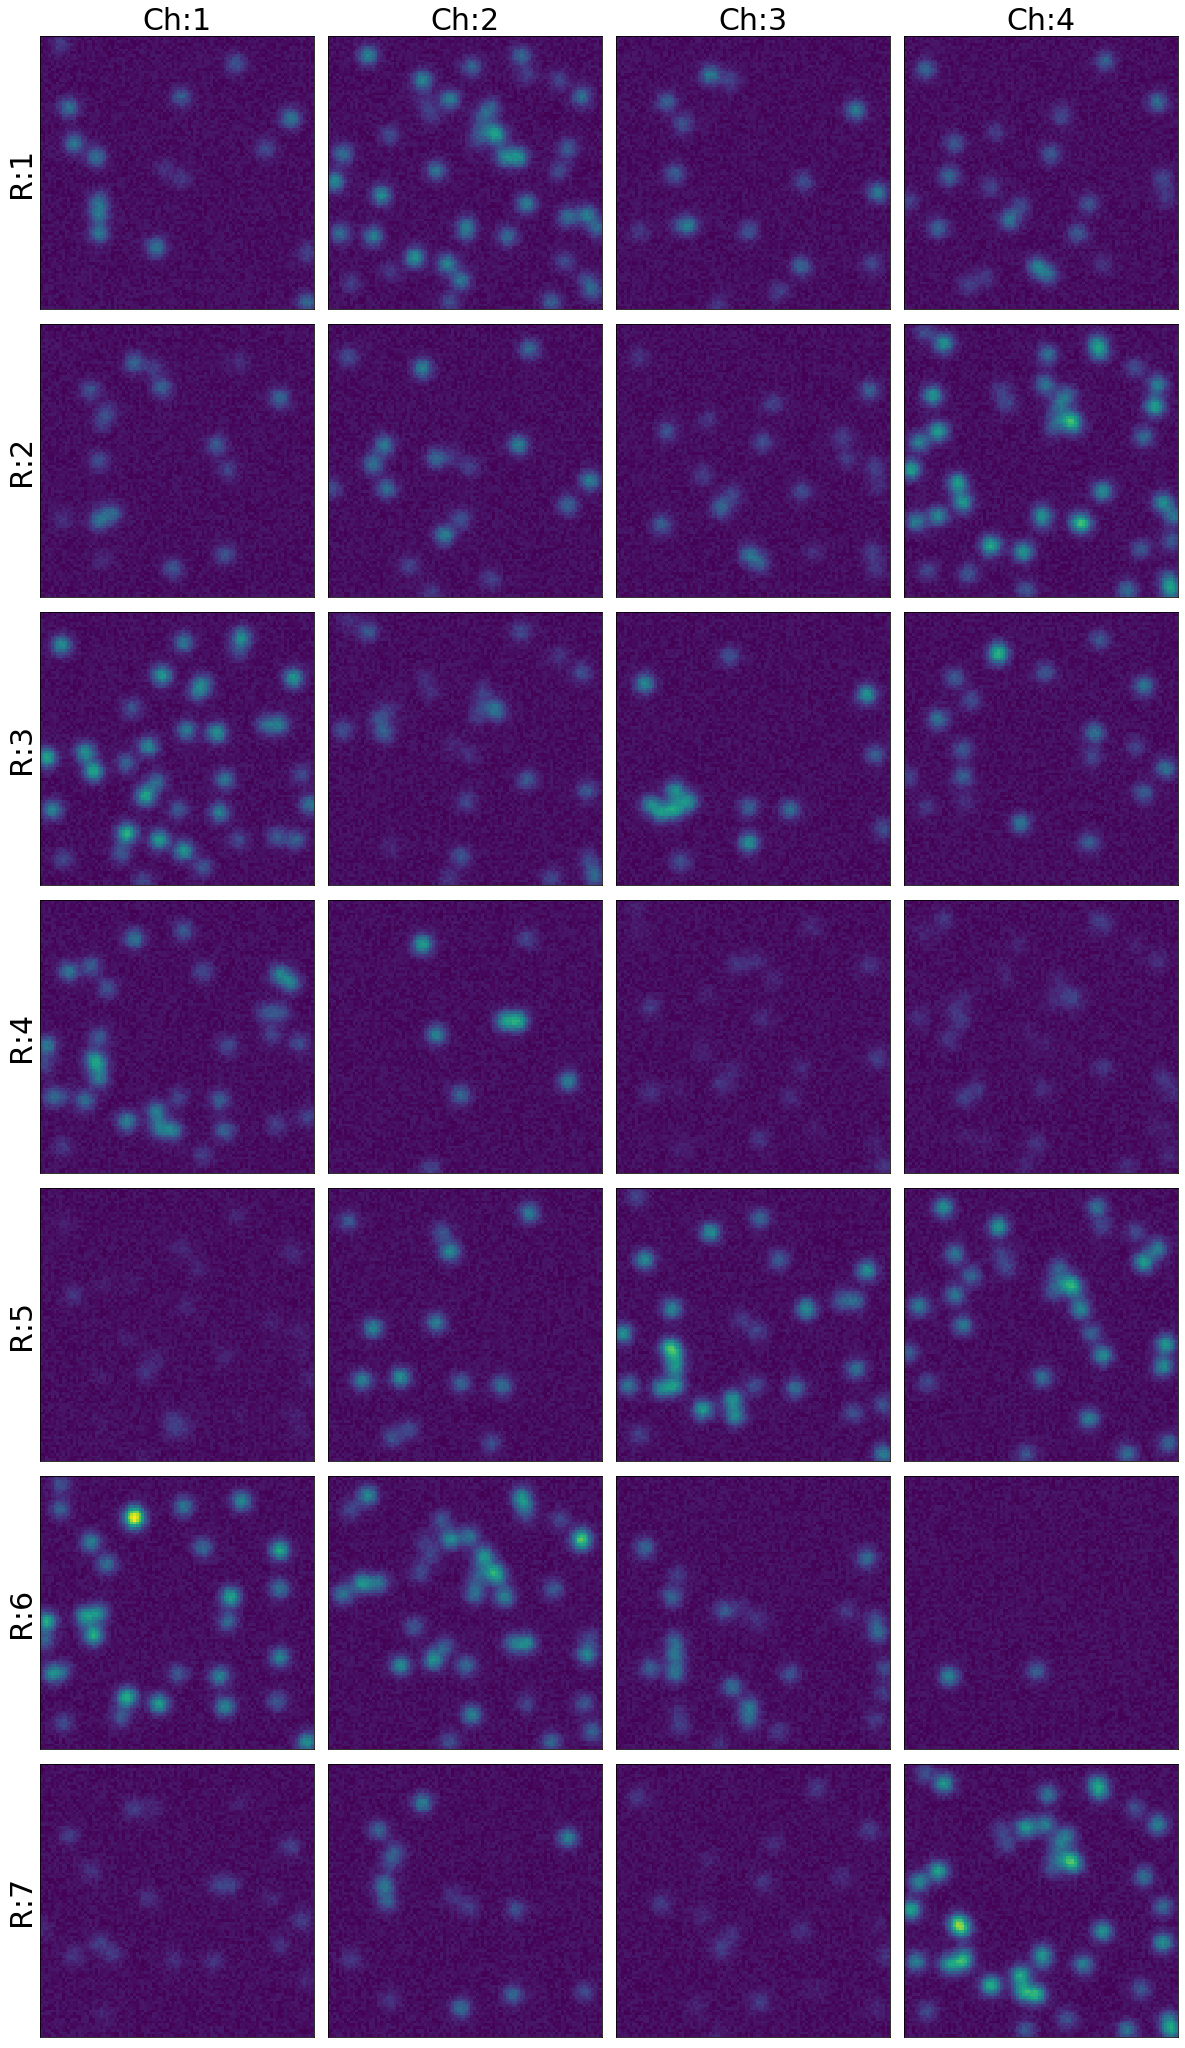

In [11]:
with AnimAcross(columns=X.shape[-1],ratio=.95) as a:
    for r in range(X.shape[-2]):
        for c in range(X.shape[-1]):
            ~a
            plt.imshow(X[:,:,r,c],vmin=0,vmax=X.max())
            plt.xticks([])
            plt.yticks([])
            if r==0:
                plt.title(f"Ch:{c+1}",fontsize=30)
            if c==0:
                plt.ylabel(f"R:{r+1}",fontsize=30)


we never went the wrong way!
final reconstruction loss per obs 0.002091726376202209
final L1 loss perobs 0.002628714868865898
final loss 0.004720441245068107


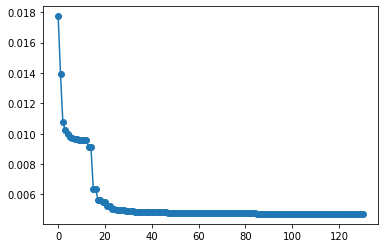

In [12]:
model2=barcoderegression.parameters.Model(
    model.B,
    barcoderegression.blurkernels.ContiguousBlur(spatial_dims,[2.5,2.5]),
#     barcoderegression.blurkernels.NoBlur(),
    M=model.M,lam=0.1)

print("initialization")
trainer=barcoderegression.training.Trainer(X,model2)
trange=tqdm.notebook.tqdm(range(10))
for i in trange:
    trainer.update(nms=['F'])
    trange.set_description(str(trainer.losses[-1]['reconstruction']))
    
print("fine tuning")
trange=tqdm.notebook.tqdm(range(20))
for i in trange:
    trainer.update(nms=['F','varphi','alpha','rho','a','b'])
    trange.set_description(str(trainer.losses[-1]['reconstruction']))
    
trainer.status()

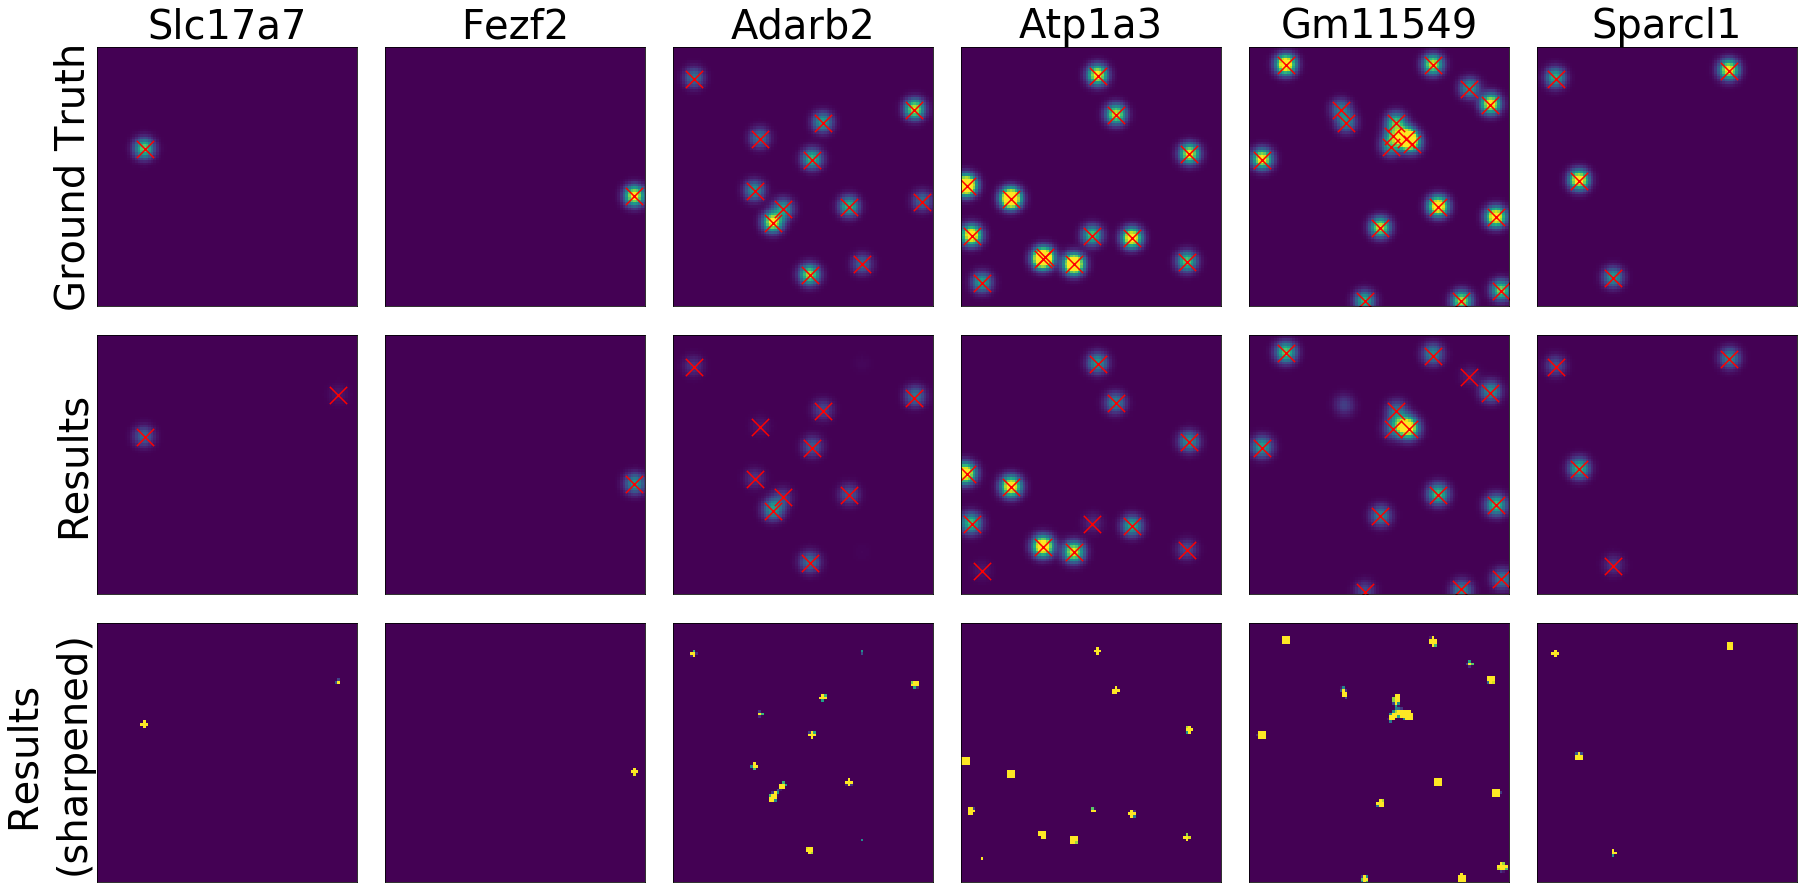

In [13]:
F=model.F_scaled(blurred=False)
F_blurred=model.F_scaled(blurred=True)

F2=model2.F_scaled(blurred=False)
F_blurred2=model2.F_scaled(blurred=True)

js=[23,26,27,49,60,77]

THRESH=7

with AnimAcross(columns=len(js),ratio=.9) as a:
    for i,j in enumerate(js):
        ~a
        plt.title(gene_names[j],fontsize=40)
        if i==0:
            plt.ylabel("Ground Truth",fontsize=40)
            
        # plot the blurred version of the ground truth
        plt.imshow(F_blurred[:,j].reshape(spatial_dims),vmax=4)
        
        # ground truth: find polony positions: all nonzero values in model.F
        locs=np.c_[np.where(F[:,j].reshape(spatial_dims)>0)]
        
        # scatterplot the polony positions
        plt.scatter(locs[:,1],locs[:,0],marker='x',color='red',s=300)
        
        plt.xticks([]); plt.yticks([]); plt.xlim(0,spatial_dims[1]-1); plt.ylim(spatial_dims[0]-1,0)

    for i,j in enumerate(js):
        ~a
        if i==0:
            plt.ylabel("Results",fontsize=40)
            
        # plot the learned spatial loadings
        plt.imshow(F_blurred2[:,j].reshape(spatial_dims),vmax=4)
        
        # find polony positions in the learned model
        locs=skimage.feature.peak_local_max(F2[:,j].reshape(spatial_dims),threshold_abs=THRESH,
                                           exclude_border=False)
        
        # scatterplot the polony positions
        plt.scatter(locs[:,1],locs[:,0],marker='x',color='red',s=300)
        
        
        plt.xticks([]); plt.yticks([]); plt.xlim(0,spatial_dims[1]-1); plt.ylim(spatial_dims[0]-1,0)
        
    for i,j in enumerate(js):
        ~a
        if i==0:
            plt.ylabel("Results \n(sharpened)",fontsize=40)
            
        # plot the learned spatial loadings
        plt.imshow(F2[:,j].reshape(spatial_dims),vmax=4)
        
        # find polony positions in the learned model
        locs=skimage.feature.peak_local_max(F2[:,j].reshape(spatial_dims),threshold_abs=THRESH,
                                           exclude_border=False)
        
        # scatterplot the polony positions
#         plt.scatter(locs[:,1],locs[:,0],marker='x',color='red',s=300)
        
        
        plt.xticks([]); plt.yticks([]); plt.xlim(0,spatial_dims[1]-1); plt.ylim(spatial_dims[0]-1,0)
        